In [87]:
import os
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import glob
import pickle
import scipy.stats as ss
import time
import copy
import bilby
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt

%matplotlib inline

import lalsimulation as lalsim
import lal
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters
from bilby.gw.prior import BBHPriorDict
from bilby.gw.source import lal_binary_black_hole


def get_gwpy_mean_psd (psd_data, fs = 4096, 
                      fftlength=32,
                      low_frequency = 16,
                      method = 'welch'):
    psd = psd_data.psd(fftlength=fftlength,overlap=0.0,method=method)
    return np.array(psd.frequencies), np.array(psd.value)

In [88]:
def estimate_mc_on_grid (inj_idx,
                         injections,
                         analysis_data_frame,
                         analysis_data_channel,
                         psd_data_frame,
                         psd_data_channel,
                         det = "V1",
                         duration = 4,
                         psd_duration = 512,
                         sampling_frequency = 2048,
                         minimum_frequency = 20,
                         maximum_frequency = 800,
                         reference_frequency = 20,
                         geocent_time_correction = 0
        ):


    injection_parameters = injections.iloc[inj_idx].to_dict()
    injection_parameters['geocent_time'] =  injection_parameters['geocent_time'] + geocent_time_correction
    param_dict = injection_parameters

    mc_inj = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
    z = bilby.gw.conversion.luminosity_distance_to_redshift(injection_parameters['luminosity_distance'])


    trigger_time= injections['geocent_time'][inj_idx]
    start_time = trigger_time - 3
    end_time   = start_time + duration
    psd_start_time = start_time + 8
    psd_end_time = psd_start_time + psd_duration
    #trigger_time = end_time - 1

    waveform_approximant="IMRPhenomPv2"

    if analysis_data_channel == None:
        analysis_data = TimeSeries.read(
            analysis_data_frame, 
            start = start_time, 
            end = end_time
        )
    else:
        analysis_data = TimeSeries.read(
            analysis_data_frame, 
            analysis_data_channel,
            start = start_time, 
            end = end_time
        )

    waveform_arguments=dict(minimum_frequency=10.0)
    params_new, _ = convert_to_lal_binary_black_hole_parameters(injection_parameters)
    chirp_time = lalsim.SimInspiralChirpTimeBound(
        10,
        params_new["mass_1"] * lal.MSUN_SI,
        params_new["mass_2"] * lal.MSUN_SI,
        params_new["a_1"] * np.cos(params_new["tilt_1"]),
        params_new["a_2"] * np.cos(params_new["tilt_2"]),
    )
    chirp_time = max(2 ** (int(np.log2(chirp_time)) + 1), 4)
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=chirp_time,
        sampling_frequency=sampling_frequency,
        start_time=injection_parameters["geocent_time"] + 0.2 - chirp_time,
        frequency_domain_source_model=lal_binary_black_hole,
        parameter_conversion=convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=dict(minimum_frequency=10.0),
    )

    ifos = bilby.gw.detector.InterferometerList([det])
    ifos[0].strain_data.set_from_gwpy_timeseries(analysis_data)

    if psd_data_frame is not None:
        if psd_data_channel == None:
            psd_data = TimeSeries.read(
                psd_data_frame, 
                start = psd_start_time, 
                end = psd_end_time
            )
        else:
            psd_data = TimeSeries.read(
                psd_data_frame, psd_data_channel, 
                start = psd_start_time, 
                end = psd_end_time
            )

        psd_gwpy = get_gwpy_mean_psd (
            psd_data, 
            fs = sampling_frequency, 
            low_frequency=minimum_frequency,
            fftlength=32, 
            method = 'welch'
        )

        np.savetxt(
            fname = psd_file, 
            X = np.array([ psd_gwpy[0][:-1], psd_gwpy[1][:-1] ]).T
        )
        
        ifos[0].power_spectral_density.psd_file = psd_file

    
    priors = BBHPriorDict()
    priors['chirp_mass']  = bilby.core.prior.Uniform(name='chirp_mass', minimum=10.0, maximum=85, unit='$M_{\odot}$', boundary='reflective')
    for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
                'dec', 'phase', 'theta_jn', 'luminosity_distance', 'geocent_time']:
        priors[key] = injection_parameters[key]

    priors['mass_ratio'] = bilby.gw.conversion.component_masses_to_mass_ratio(injection_parameters['mass_1'], injection_parameters['mass_2'])

    likelihood = bilby.gw.GravitationalWaveTransient(
            interferometers=ifos, 
            waveform_generator=waveform_generator,
            reference_frame= 'sky',
            time_reference= 'geocent',
            time_marginalization = False,
            distance_marginalization = False, 
            jitter_time= False,
            phase_marginalization = False,
            priors = priors)    


    Mc_min = max(5, mc_inj - 0.05)
    Mc_max = min(90, mc_inj + 0.05)
    mc_grid = np.linspace(Mc_min, Mc_max,1000)
    LLR = np.zeros(mc_grid.shape)

    for i in range(len(LLR)):
        mass_ratio = bilby.gw.conversion.component_masses_to_mass_ratio(param_dict['mass_1'], param_dict['mass_2'])
        mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_grid[i],mass_ratio)
        m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(mass_ratio, mtot)
        param_dict['mass_1'] = m1
        param_dict['mass_2'] = m2
        likelihood.parameters = param_dict

        LLR[i] = likelihood.log_likelihood_ratio()
    

    return mc_grid, np.exp(LLR-max(LLR)), mc_inj


In [89]:
datadir = "/home/weizmann.kiendrebeogo/DeepClean/DeepClean_CIT/Friday_Work/data"
dc_noise_only        = os.path.join(datadir, 'deepclean-NoiseOnly.gwf')
dc_noise_plus_signal = os.path.join(datadir, 'deepclean-NoisePlusSignal.gwf')
org_noise_only       = os.path.join(datadir, 'original-NoiseOnly.h5')
org_noise_plus_signal= os.path.join(datadir, 'original-NoisePlusSignal.h5')
signal_only          = os.path.join(datadir, 'GW_injected_signal.hdf5')
inj_file             = os.path.join(datadir, 'INJ-1265127585-4096.csv')
inj_file_json        = os.path.join(datadir, 'INJ-1265127585-4096.json')


channel = 'V1:Hrec_hoft_raw_20000Hz'  # Original Channel channel
channel_DC="V1:Hrec_hoft_raw_20000Hz_DC"  # Cleanning channel
channel_INJ = "V1:DC_INJ"                # Injected GW signal channel

injections = pd.read_csv(inj_file)


In [90]:
injections

,Unnamed: 0,mass_1,mass_2,luminosity_distance,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,dec,ra,theta_jn,psi,phase,geocent_time
0,0,21.657061,8.942829,20.337186,0.316401,0.421803,0.0,0.0,0.0,0.0,1.372350,0.351124,1.571572,1.093520,4.623716,1.265128e+09
1,1,17.544304,10.600881,29.596042,0.771905,0.188531,0.0,0.0,0.0,0.0,0.038757,3.129534,2.167390,0.874952,5.544598,1.265128e+09
2,2,18.290719,10.537260,21.154880,0.877212,0.908567,0.0,0.0,0.0,0.0,0.258815,4.949516,1.682590,0.478230,5.549510,1.265128e+09
3,3,16.838082,13.765906,19.765857,0.567760,0.365852,0.0,0.0,0.0,0.0,0.019673,4.494605,0.856310,0.637793,4.287117,1.265128e+09
4,4,19.579346,10.257479,16.910476,0.258311,0.717408,0.0,0.0,0.0,0.0,0.849165,1.901740,2.322145,2.245926,1.694800,1.265128e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,123,18.632911,10.719888,19.200438,0.697003,0.673823,0.0,0.0,0.0,0.0,-0.906635,1.968273,1.644622,2.709033,0.383454,1.265132e+09
124,124,19.045053,11.166912,26.226166,0.524494,0.254161,0.0,0.0,0.0,0.0,0.636787,1.319891,0.776720,0.102622,2.239597,1.265132e+09
125,125,18.719389,8.516774,26.472437,0.345161,0.712868,0.0,0.0,0.0,0.0,-0.680273,0.548604,1.571081,1.923266,0.022102,1.265132e+09
126,126,20.464251,8.719971,28.141396,0.650938,0.067115,0.0,0.0,0.0,0.0,0.942930,3.119290,1.293614,2.005906,3.245518,1.265132e+09


In [91]:
inj_idx = 10
injection_parameters = injections.iloc[inj_idx].to_dict()
param_dict = injection_parameters
param_dict


{'Unnamed: 0': 10.0,
 'mass_1': 13.909942065976097,
 'mass_2': 13.045624329101914,
 'luminosity_distance': 19.645249211791665,
 'a_1': 0.3332972363297479,
 'a_2': 0.7816245551500934,
 'tilt_1': 0.0,
 'tilt_2': 0.0,
 'phi_12': 0.0,
 'phi_jl': 0.0,
 'dec': 0.5223989018538194,
 'ra': 6.114564881024543,
 'theta_jn': 1.4717742545294368,
 'psi': 1.30225592550328,
 'phase': 5.496084823244368,
 'geocent_time': 1265127905.0}

In [92]:
param_dict['geocent_time']

1265127905.0

## plotting an examples of data 

(1265127904.95, 1265127905.01)

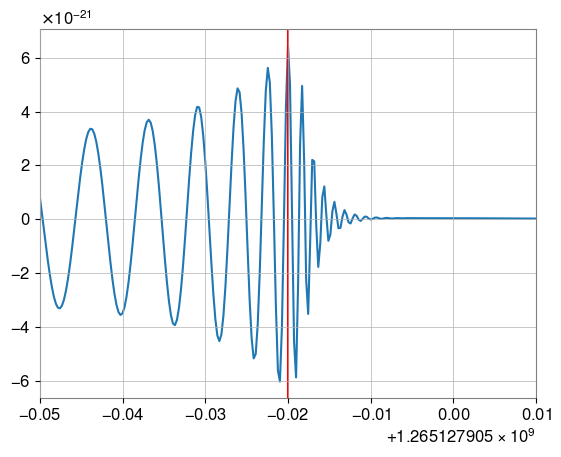

In [67]:
signal = TimeSeries.read(
            signal_only, 
            channel_INJ,
            start = param_dict['geocent_time']-40, 
            end = param_dict['geocent_time']+1
        )
plt.plot(signal)
plt.axvline(param_dict['geocent_time']-0.02 , color = 'red')
plt.axvline(param_dict['geocent_time']-32, color = 'red')
plt.xlim(param_dict['geocent_time']-0.05, param_dict['geocent_time']+0.01)

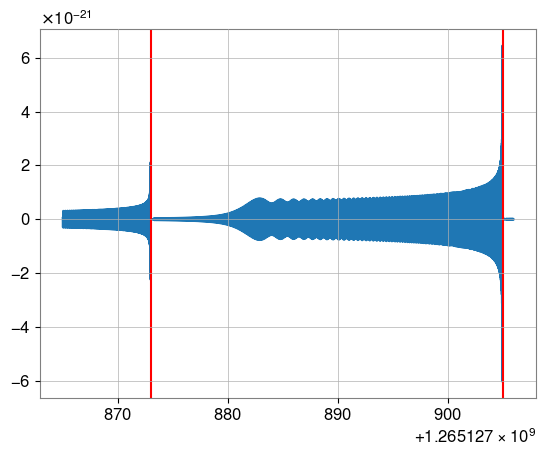

In [27]:
noise_plus_signal_dc = TimeSeries.read(
            dc_noise_plus_signal, 
            channel_DC,
            start = param_dict['geocent_time']-40, 
            end = param_dict['geocent_time']+1
        )

noise_only_dc = TimeSeries.read(
            dc_noise_only, 
            channel_DC,
            start = param_dict['geocent_time']-40, 
            end = param_dict['geocent_time']+1
        )


plt.plot(noise_plus_signal_dc - noise_only_dc)
plt.axvline(param_dict['geocent_time'], color = 'red')
plt.axvline(param_dict['geocent_time']-32, color = 'red')

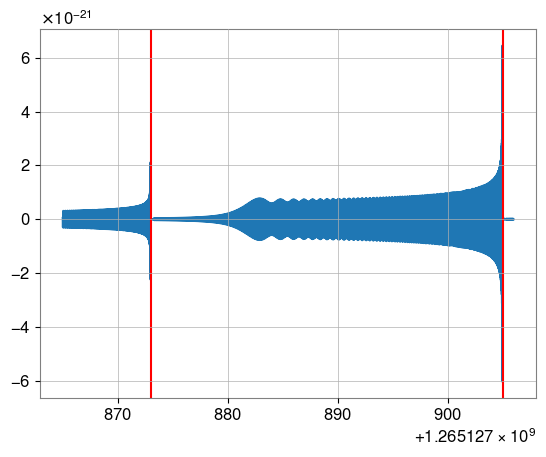

In [28]:
noise_plus_signal_org = TimeSeries.read(
            org_noise_plus_signal, 
            channel,
            start = param_dict['geocent_time']-40, 
            end = param_dict['geocent_time']+1
        )

noise_only_org = TimeSeries.read(
            org_noise_only, 
            channel,
            start = param_dict['geocent_time']-40, 
            end = param_dict['geocent_time']+1
        )


plt.plot(noise_plus_signal_org - noise_only_org)
plt.axvline(param_dict['geocent_time'], color = 'red')
plt.axvline(param_dict['geocent_time']-32, color = 'red')

(140, 165)

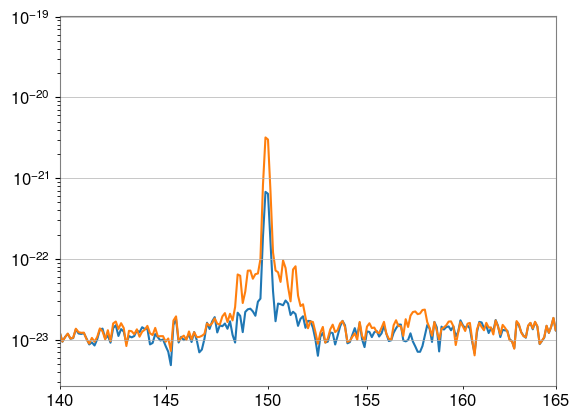

In [35]:
pred = noise_plus_signal_dc - noise_plus_signal_org
pred_asd = pred.asd(fftlength=8, method = 'welch', overlap = 0)
asd_noise_plus_signal_dc = noise_plus_signal_dc.asd(fftlength=8, method = 'welch', overlap = 0)
asd_noise_plus_signal_org = noise_plus_signal_org.asd(fftlength=8, method = 'welch', overlap = 0)


plt.loglog(asd_noise_plus_signal_dc)
plt.loglog(asd_noise_plus_signal_org)
plt.xlim(140,165)



In [93]:
psd_file = 'gwpy_psd_original.txt'
results = estimate_mc_on_grid (inj_idx,
                         injections,
                         analysis_data_frame = signal_only,
                         analysis_data_channel = channel_INJ,
                         psd_data_frame = org_noise_only,
                         psd_data_channel = channel,
                         det = "V1",
                         duration = 4,
                         psd_duration = 512,
                         sampling_frequency = 4096,
                         minimum_frequency = 20,
                         maximum_frequency = 2048,
                         reference_frequency = 20,
                         geocent_time_correction = 0.00011706352233886719
        )

15:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:43 bilby INFO    : No prior given, using default BBH priors in /cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


(11.70585234780913, 11.745852347809128)

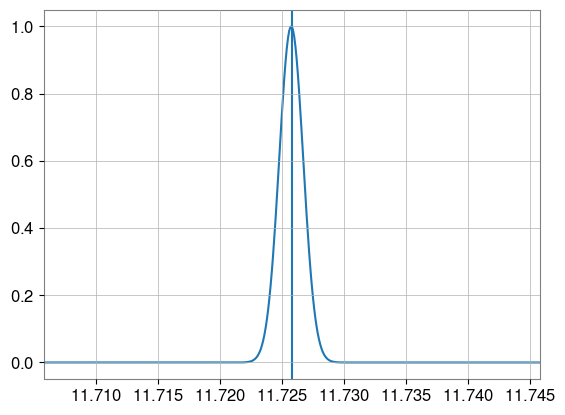

In [96]:
plt.plot(results[0], results[1])
plt.axvline(results[2])
plt.xlim(results[2]-0.02, results[2]+0.02)

In [211]:
dict_out = {}

### On zero-noise injection (the strain contain only the signal - no noise), Using designed noise curve (AdLIGO)


14:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:45 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
14:45 bilby INFO    : Generating frequency domain strain from given time domain strain.
14:45 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


(31.536853208872486, 41.536853208872486)

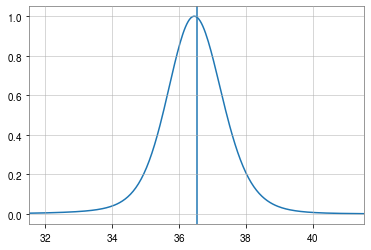

In [212]:
label = 'zero-noise-designed'
output = estimate_mc_on_grid (inj_idx = 8,
                         injections = injections,
                         analysis_data_frame = frame_zero_noise,
                         analysis_data_channel = None,
                         psd_data_frame = None,
                         psd_data_channel = None,
                         geocent_time_correction = 0 )

dict_out[label] = output
plt.plot(output[0], output[1])
plt.axvline(output[2])
plt.xlim(output[2]-5, output[2]+5)

### Zero-noise injection with estimated PSD

14:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:49 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
14:49 bilby INFO    : Generating frequency domain strain from given time domain strain.
14:49 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


(59.80552258554245, 69.80552258554245)

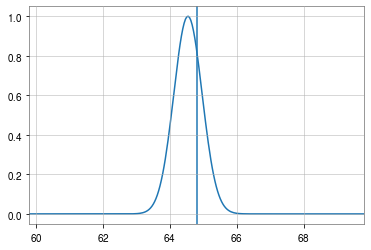

In [219]:
label = 'zero-noise-estimated'
output = estimate_mc_on_grid (inj_idx = 10,
                         injections = injections,
                         analysis_data_frame = frame_zero_noise,
                         analysis_data_channel = None,
                         psd_data_frame = frame_dc_offline_noinj,
                         psd_data_channel = channel_DC,
                         geocent_time_correction = 0 )

dict_out[label] = output
plt.plot(output[0], output[1])
plt.axvline(output[2])
plt.xlim(output[2]-5, output[2]+5)

### On offline deepclean strain with estimated PSD

14:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:50 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
14:50 bilby INFO    : Generating frequency domain strain from given time domain strain.
14:50 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


(59.80552258554245, 69.80552258554245)

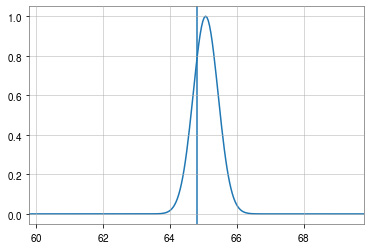

In [220]:
label= 'offline-dc'
output = estimate_mc_on_grid (inj_idx = 10,
                         injections = injections,
                         analysis_data_frame = frame_dc_offline_injected,
                         analysis_data_channel = channel_DC,
                         psd_data_frame = frame_dc_offline_noinj,
                         psd_data_channel = channel_DC,
                         geocent_time_correction = 0 )

dict_out[label] = output
plt.plot(output[0], output[1])
plt.axvline(output[2])
plt.xlim(output[2]-5, output[2]+5)

### On online DeepClean strain with estimated offline PSD

15:02 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:02 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
15:02 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:02 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


(59.80552258554245, 69.80552258554245)

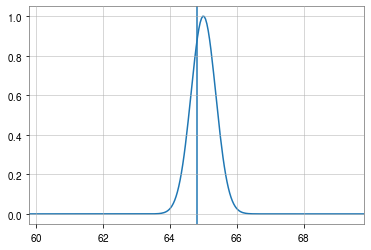

In [224]:
label= 'online-dc-offline-psd'
output = estimate_mc_on_grid (inj_idx = 10,
                         injections = injections,
                         analysis_data_frame = frames_dc_online_injected,
                         analysis_data_channel = channel_DC,
                         psd_data_frame = frame_dc_offline_noinj,
                         psd_data_channel = channel_DC,
                         geocent_time_correction = -1 )

dict_out[label] = output
plt.plot(output[0], output[1])
plt.axvline(output[2])
plt.xlim(output[2]-5, output[2]+5)

### Online DeepClean strain with online PSD

15:02 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:02 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
15:02 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:02 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


(59.80552258554245, 69.80552258554245)

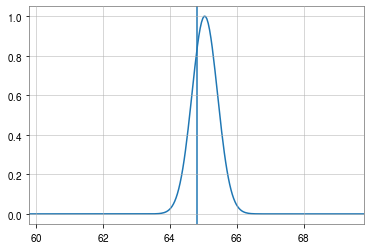

In [225]:
label= 'online-dc'

output = estimate_mc_on_grid (inj_idx = 10,
                         injections = injections,
                         analysis_data_frame = frames_dc_online_injected,
                         analysis_data_channel = channel_DC,
                         psd_data_frame = frames_dc_online_noinj,
                         psd_data_channel = channel_DC,
                         geocent_time_correction = -1 )
dict_out[label] = output
plt.plot(output[0], output[1])
plt.axvline(output[2])
plt.xlim(output[2]-5, output[2]+5)

### Online original (unclean) strain (written by dc output) with unclean offline psd

15:04 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:04 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
15:04 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:04 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


(59.80552258554245, 69.80552258554245)

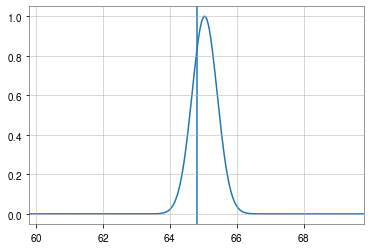

In [227]:
label='online-org'

output = estimate_mc_on_grid (inj_idx = 10,
                         injections = injections,
                         analysis_data_frame = frames_org_online_injected,
                         analysis_data_channel = channel,
                         psd_data_frame = frames_org_online_noinj,
                         psd_data_channel = channel,
                         geocent_time_correction = 0 )
dict_out[label] = output
plt.plot(output[0], output[1])
plt.axvline(output[2])
plt.xlim(output[2]-5, output[2]+5)

Text(0.5, 0, 'chirp mass ')

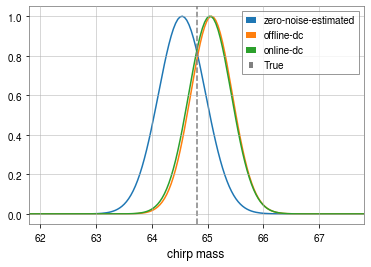

In [229]:
k1 = 'zero-noise-estimated' 
k2 = 'offline-dc'
k3 = 'online-dc' 

plt.plot(dict_out[k1][0],dict_out[k1][1], label=k1)
plt.plot(dict_out[k2][0],dict_out[k2][1], label=k2)
plt.plot(dict_out[k3][0],dict_out[k3][1], label=k3)

plt.axvline(dict_out[k1][2], label='True', color='grey', ls='dashed')
plt.legend()
plt.xlim(mc_inj-3, mc_inj+3)
plt.xlabel('chirp mass ')

In [87]:

injection_parameters = injections.iloc[inj_idx].to_dict()
param_dict = injection_parameters

mc_inj = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])
z = bilby.gw.conversion.luminosity_distance_to_redshift(injection_parameters['luminosity_distance'])
mc_inj


trigger_time= injections['geocent_time'][inj_idx]
start_time = trigger_time - 3
end_time   = start_time + duration
psd_start_time = start_time + 8
psd_end_time = psd_start_time + psd_duration
#trigger_time = end_time - 1


det = "H1"
waveform_approximant="IMRPhenomPv2pseudoFourPN"

analysis_data = TimeSeries.read(
    frames_org_online_injected, channel, 
    start = start_time, 
    end = end_time
)

psd_data = TimeSeries.read(
    frame_org_offline_noinj, channel, 
    start = psd_start_time, 
    end = psd_end_time
)


psd_gwpy = get_gwpy_mean_psd (
    psd_data, 
    fs = sampling_frequency, 
    low_frequency=minimum_frequency,
    fftlength=32, 
    method = 'welch'
)


np.savetxt(
    fname = psd_file, 
    X = np.array([ psd_gwpy[0][:-1], psd_gwpy[1][:-1] ]).T
)



waveform_arguments=dict(minimum_frequency=10.0)
'''waveform_arguments = dict(waveform_approximant=waveform_approximant,
        reference_frequency=reference_frequency, 
        minimum_frequency=minimum_frequency,
        maximum_frequency=maximum_frequency)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, 
    sampling_frequency=sampling_frequency,
    start_time = start_time,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)
'''

params_new, _ = convert_to_lal_binary_black_hole_parameters(injection_parameters)
chirp_time = lalsim.SimInspiralChirpTimeBound(
    10,
    params_new["mass_1"] * lal.MSUN_SI,
    params_new["mass_2"] * lal.MSUN_SI,
    params_new["a_1"] * np.cos(params_new["tilt_1"]),
    params_new["a_2"] * np.cos(params_new["tilt_2"]),
)
chirp_time = max(2 ** (int(np.log2(chirp_time)) + 1), 4)
waveform_generator = bilby.gw.WaveformGenerator(
    duration=chirp_time,
    sampling_frequency=sampling_frequency,
    start_time=injection_parameters["geocent_time"] + 0.2 - chirp_time,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=dict(minimum_frequency=10.0),
)


ifos = bilby.gw.detector.InterferometerList([det])
ifos[0].power_spectral_density.psd_file = psd_file
ifos[0].strain_data.set_from_gwpy_timeseries(analysis_data)
#ifos.inject_signal(waveform_generator=waveform_generator,
#                       parameters=injection_parameters)

priors = BBHPriorDict()
priors['chirp_mass']  = bilby.core.prior.Uniform(name='chirp_mass', minimum=40.0, maximum=70, unit='$M_{\odot}$', boundary='reflective')
#priors['geocent_time']  = bilby.core.prior.Uniform(name='geocent_time', minimum=start_time, maximum=end_time, boundary='reflective')

#priors['luminosity_distance'] =  bilby.gw.prior.UniformComovingVolume(name='luminosity_distance', minimum=100, maximum=3000, unit='Mpc')
#priors['mass_ratio']  = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.2, maximum=1.0, boundary='reflective')
#mass_ratio = bilby.core.prior.Constraint(name='mass_ratio', minimum=0.25, maximum=1.0)
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra',
            'dec', 'phase', 'theta_jn', 'luminosity_distance', 'geocent_time']:
    priors[key] = injection_parameters[key]

priors['mass_ratio'] = bilby.gw.conversion.component_masses_to_mass_ratio(injection_parameters['mass_1'], injection_parameters['mass_2'])
#priors['geocent_time'] += 1 

# Perform a check that the prior does not extend to a parameter space longer than the data
#priors.validate_prior(duration, minimum_frequency)

likelihood = bilby.gw.GravitationalWaveTransient(
        interferometers=ifos, 
        waveform_generator=waveform_generator,
        reference_frame= 'sky',
        time_reference= 'geocent',
        time_marginalization = False,
        distance_marginalization = False, 
        jitter_time= False,
        phase_marginalization = False,
        priors = priors)    


Mc_min = max(5, mc_inj - 30)
Mc_max = min(90, mc_inj + 30)
mc_grid = np.linspace(Mc_min, Mc_max,1000)
LLR = np.zeros(mc_grid.shape)

for i in range(len(LLR)):
    mass_ratio = bilby.gw.conversion.component_masses_to_mass_ratio(param_dict['mass_1'], param_dict['mass_2'])
    mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(mc_grid[i],mass_ratio)
    m1, m2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(mass_ratio, mtot)
    param_dict['mass_1'] = m1
    param_dict['mass_2'] = m2
    likelihood.parameters = param_dict

    LLR[i] = likelihood.log_likelihood_ratio()
    


14:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:44 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
14:44 bilby INFO    : Generating frequency domain strain from given time domain strain.
14:44 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


(59.80552258554245, 69.80552258554245)

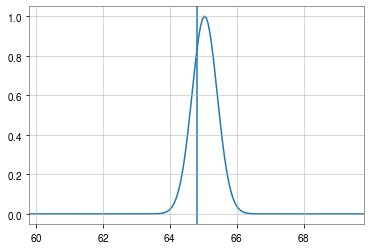

In [89]:
plt.plot(mc_grid, np.exp(LLR-max(LLR)) )
plt.axvline(mc_inj)
plt.xlim(mc_inj -5, mc_inj +5)

### Is there a time shift added to the frames written?

#### Yes there is one that is due to not accounting the aggregation latency while writing the frames. Currently the plots (above) are remade by accounting a shift factor in the data but the long-term solution is to correct this in the code.  

In [168]:
start_time_new = start_time - 10
end_time_new   = end_time   + 10

In [169]:
data_org_offline_injected = TimeSeries.read(
    frame_org_offline_injected, channel, start = start_time_new, end = end_time_new)


In [170]:
data_org_offline_noinj = TimeSeries.read(
    frame_org_offline_noinj, channel, start = start_time_new, end = end_time_new)


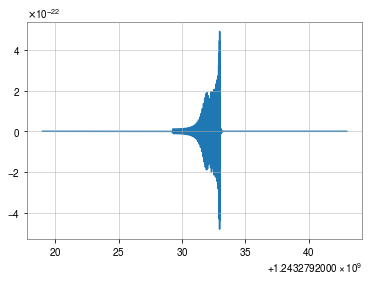

In [171]:
plt.plot(data_org_offline_injected - data_org_offline_noinj)

In [172]:
data_org_online_injected = TimeSeries.read(
    frames_org_online_injected, channel, start = start_time_new, end = end_time_new)

data_org_online_injected_spit_by_dc = TimeSeries.read(
    frames_org_online_injected_spit_by_dc, channel, start = start_time_new, end = end_time_new)

data_org_online_noinj_spit_by_dc = TimeSeries.read(
    frames_org_online_noinj_spit_by_dc, channel, start = start_time_new, end = end_time_new)


(1243279229.0, 1243279233.0)

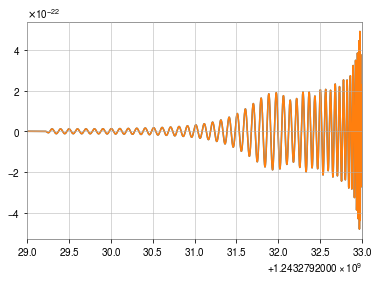

In [173]:
plt.plot(data_org_online_injected.times, data_org_online_injected - data_org_offline_noinj)
plt.plot(data_org_online_injected_spit_by_dc.times.value + 1, data_org_online_injected_spit_by_dc - data_org_online_noinj_spit_by_dc)
plt.xlim(start_time, end_time)


In [174]:
data_dc_online_injected = TimeSeries.read(
    frames_dc_online_injected, channel_DC, start = start_time_new, end = end_time_new)

data_dc_online_noinj = TimeSeries.read(
    frames_dc_online_noinj, channel_DC, start = start_time_new, end = end_time_new)




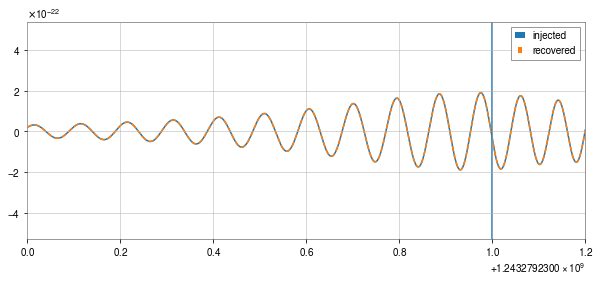

In [175]:
plt.figure(figsize=(10,4))
plt.plot(data_org_online_injected_spit_by_dc - data_org_online_noinj_spit_by_dc)
plt.plot(data_dc_online_injected - data_dc_online_noinj, ls='dashed')
plt.xlim(start_time+1, end_time-1.8)
plt.axvline(injection_parameters['geocent_time']-1)
plt.legend(['injected','recovered'])

In [165]:
dict_llr.keys()


dict_keys(['zero-noise-designed', 'zero_noise', 'zero-noise-estimated', 'offline-dc', 'online-dc', 'online-org'])